# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [1]:
# Run some setup code for this notebook.

import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

from __future__ import print_function

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

In [2]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


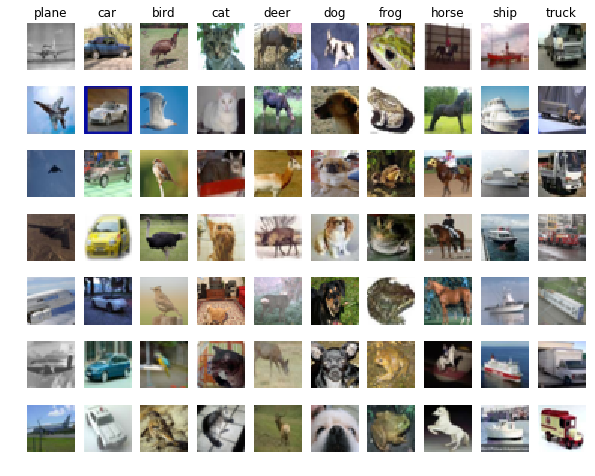

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[ 130.64189796  135.98173469  132.47391837  130.05569388  135.34804082
  131.75402041  130.96055102  136.14328571  132.47636735  131.48467347]


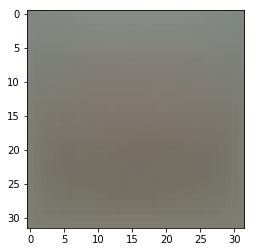

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [9]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 

loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print('loss: %f' % (loss, ))

loss: 9.703816


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [10]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)

# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: -7.269668 analytic: -7.269668, relative error: 3.196165e-11
numerical: -6.418072 analytic: -6.418072, relative error: 1.998829e-11
numerical: -5.226503 analytic: -5.226503, relative error: 1.868887e-11
numerical: -14.088717 analytic: -14.088717, relative error: 1.513495e-11
numerical: 8.105405 analytic: 8.105405, relative error: 4.267459e-11
numerical: -19.239759 analytic: -19.239759, relative error: 1.057343e-11
numerical: -5.986743 analytic: -5.986743, relative error: 5.270402e-13
numerical: 4.928632 analytic: 4.928632, relative error: 3.141204e-11
numerical: -8.130246 analytic: -8.130246, relative error: 2.064980e-11
numerical: -13.135940 analytic: -13.135940, relative error: 2.668456e-11
numerical: -13.060103 analytic: -13.060103, relative error: 4.003361e-11
numerical: -6.164754 analytic: -6.164754, relative error: 5.850109e-12
numerical: -13.707695 analytic: -13.707695, relative error: 2.218072e-11
numerical: 14.522732 analytic: 14.522732, relative error: 4.460062e-11


### Inline Question 1:
It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

**Your Answer:** *fill this in.*

In [11]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.703816e+00 computed in 0.070027s
Vectorized loss: 9.703816e+00 computed in 0.005233s
difference: -0.000000


In [12]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
_, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
_, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

Naive loss and gradient: computed in 0.069786s
Vectorized loss and gradient: computed in 0.002519s
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [13]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 801.767047
iteration 100 / 1500: loss 289.607894
iteration 200 / 1500: loss 108.174081
iteration 300 / 1500: loss 42.625712
iteration 400 / 1500: loss 18.810009
iteration 500 / 1500: loss 10.405400
iteration 600 / 1500: loss 7.143154
iteration 700 / 1500: loss 6.508818
iteration 800 / 1500: loss 5.358453
iteration 900 / 1500: loss 5.468333
iteration 1000 / 1500: loss 5.554300
iteration 1100 / 1500: loss 5.454698
iteration 1200 / 1500: loss 5.390006
iteration 1300 / 1500: loss 5.114582
iteration 1400 / 1500: loss 6.225447
That took 3.616449s


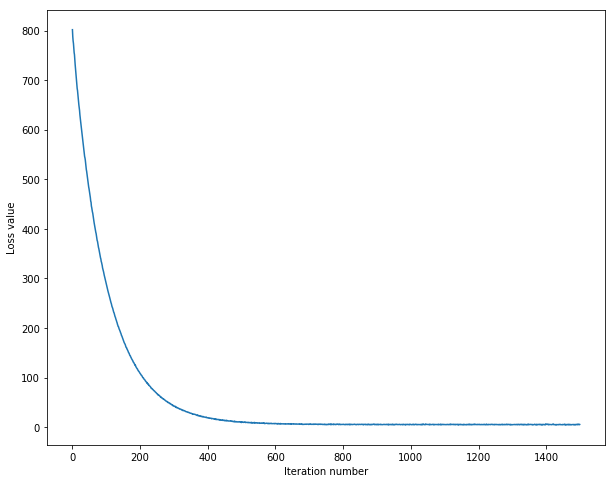

In [14]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [15]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
y_train_pred = svm.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = svm.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.370245
validation accuracy: 0.379000


In [36]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.4 on the validation set.
learning_rates = [1e-8, 3e-8, 5e-8, 7e-8, 1e-7, 3e-7, 5e-7]
regularization_strengths = [1e3, 5e3, 1e4, 2.5e4, 5e4]

# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
for lr in learning_rates:
    for reg in regularization_strengths:
        print("learning_rates: %e regularization_strengths: %e" % (lr, reg)) 
        ls = LinearSVM()
        if (lr == 1e-8):
            ls.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=8000, verbose=True)
        elif (lr == 3e-8):
            ls.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=5500, verbose=True)
        elif (lr == 5e-8):
            ls.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=4500, verbose=True)
        elif (lr == 7e-8):
            ls.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=4000, verbose=True)
        else:
            ls.train(X_train, y_train, learning_rate=lr, reg=reg,
                          num_iters=3000, verbose=True)
        ta = np.mean(y_train == ls.predict(X_train))
        va = np.mean(y_val == ls.predict(X_val))
        results[(lr, reg)] = (ta, va)
        if (va > best_val):
            best_val = va
            best_svm = ls
################################################################################
#                              END OF YOUR CODE                                #
################################################################################
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

learning_rates: 1.000000e-08 regularization_strengths: 1.000000e+03
iteration 0 / 8000: loss 60.327380
iteration 100 / 8000: loss 49.298970
iteration 200 / 8000: loss 47.534507
iteration 300 / 8000: loss 46.632253
iteration 400 / 8000: loss 44.290000
iteration 500 / 8000: loss 44.354639
iteration 600 / 8000: loss 40.915494
iteration 700 / 8000: loss 43.205099
iteration 800 / 8000: loss 41.432624
iteration 900 / 8000: loss 39.259246
iteration 1000 / 8000: loss 41.960925
iteration 1100 / 8000: loss 39.966757
iteration 1200 / 8000: loss 41.152921
iteration 1300 / 8000: loss 39.420882
iteration 1400 / 8000: loss 40.300967
iteration 1500 / 8000: loss 38.892224
iteration 1600 / 8000: loss 39.265134
iteration 1700 / 8000: loss 39.139023
iteration 1800 / 8000: loss 37.159841
iteration 1900 / 8000: loss 38.014099
iteration 2000 / 8000: loss 38.720887
iteration 2100 / 8000: loss 37.202783
iteration 2200 / 8000: loss 37.397602
iteration 2300 / 8000: loss 36.134188
iteration 2400 / 8000: loss 35.2

iteration 5000 / 8000: loss 46.589258
iteration 5100 / 8000: loss 43.868611
iteration 5200 / 8000: loss 43.036476
iteration 5300 / 8000: loss 42.258193
iteration 5400 / 8000: loss 40.539717
iteration 5500 / 8000: loss 38.497409
iteration 5600 / 8000: loss 37.355280
iteration 5700 / 8000: loss 36.690037
iteration 5800 / 8000: loss 35.162524
iteration 5900 / 8000: loss 33.962344
iteration 6000 / 8000: loss 32.898154
iteration 6100 / 8000: loss 31.870286
iteration 6200 / 8000: loss 29.897169
iteration 6300 / 8000: loss 29.705037
iteration 6400 / 8000: loss 28.032122
iteration 6500 / 8000: loss 27.950096
iteration 6600 / 8000: loss 25.930264
iteration 6700 / 8000: loss 25.722284
iteration 6800 / 8000: loss 24.853668
iteration 6900 / 8000: loss 23.641273
iteration 7000 / 8000: loss 23.059271
iteration 7100 / 8000: loss 22.090745
iteration 7200 / 8000: loss 21.969430
iteration 7300 / 8000: loss 21.061436
iteration 7400 / 8000: loss 20.415268
iteration 7500 / 8000: loss 19.795973
iteration 76

iteration 2300 / 5500: loss 29.797460
iteration 2400 / 5500: loss 29.401194
iteration 2500 / 5500: loss 28.383407
iteration 2600 / 5500: loss 27.618270
iteration 2700 / 5500: loss 27.736334
iteration 2800 / 5500: loss 28.990989
iteration 2900 / 5500: loss 27.898460
iteration 3000 / 5500: loss 27.201612
iteration 3100 / 5500: loss 26.298892
iteration 3200 / 5500: loss 26.364252
iteration 3300 / 5500: loss 26.389666
iteration 3400 / 5500: loss 26.453590
iteration 3500 / 5500: loss 26.232098
iteration 3600 / 5500: loss 25.813310
iteration 3700 / 5500: loss 25.853544
iteration 3800 / 5500: loss 24.837099
iteration 3900 / 5500: loss 24.182862
iteration 4000 / 5500: loss 25.071372
iteration 4100 / 5500: loss 25.772212
iteration 4200 / 5500: loss 23.701312
iteration 4300 / 5500: loss 23.767232
iteration 4400 / 5500: loss 24.227891
iteration 4500 / 5500: loss 22.580871
iteration 4600 / 5500: loss 22.754995
iteration 4700 / 5500: loss 23.315042
iteration 4800 / 5500: loss 22.259196
iteration 49

iteration 1400 / 5500: loss 5.654406
iteration 1500 / 5500: loss 5.759173
iteration 1600 / 5500: loss 5.648120
iteration 1700 / 5500: loss 5.581956
iteration 1800 / 5500: loss 5.479926
iteration 1900 / 5500: loss 6.105010
iteration 2000 / 5500: loss 5.259021
iteration 2100 / 5500: loss 5.596055
iteration 2200 / 5500: loss 5.660992
iteration 2300 / 5500: loss 5.852910
iteration 2400 / 5500: loss 5.791687
iteration 2500 / 5500: loss 5.550355
iteration 2600 / 5500: loss 5.756764
iteration 2700 / 5500: loss 5.523889
iteration 2800 / 5500: loss 5.072135
iteration 2900 / 5500: loss 5.282132
iteration 3000 / 5500: loss 5.712220
iteration 3100 / 5500: loss 5.351075
iteration 3200 / 5500: loss 5.241979
iteration 3300 / 5500: loss 6.065936
iteration 3400 / 5500: loss 5.406342
iteration 3500 / 5500: loss 5.468520
iteration 3600 / 5500: loss 5.634902
iteration 3700 / 5500: loss 5.902652
iteration 3800 / 5500: loss 5.587275
iteration 3900 / 5500: loss 6.021902
iteration 4000 / 5500: loss 5.587984
i

iteration 3600 / 4500: loss 4.654370
iteration 3700 / 4500: loss 5.634725
iteration 3800 / 4500: loss 5.787207
iteration 3900 / 4500: loss 5.295708
iteration 4000 / 4500: loss 5.231349
iteration 4100 / 4500: loss 5.825664
iteration 4200 / 4500: loss 4.457304
iteration 4300 / 4500: loss 5.321427
iteration 4400 / 4500: loss 4.530070
learning_rates: 5.000000e-08 regularization_strengths: 5.000000e+04
iteration 0 / 4500: loss 1525.915889
iteration 100 / 4500: loss 559.830588
iteration 200 / 4500: loss 207.713922
iteration 300 / 4500: loss 78.751243
iteration 400 / 4500: loss 32.543173
iteration 500 / 4500: loss 15.393563
iteration 600 / 4500: loss 9.210244
iteration 700 / 4500: loss 7.176314
iteration 800 / 4500: loss 6.340551
iteration 900 / 4500: loss 5.518270
iteration 1000 / 4500: loss 5.783676
iteration 1100 / 4500: loss 6.054481
iteration 1200 / 4500: loss 5.562107
iteration 1300 / 4500: loss 5.594256
iteration 1400 / 4500: loss 5.458234
iteration 1500 / 4500: loss 5.532300
iteration

iteration 3700 / 4000: loss 5.318543
iteration 3800 / 4000: loss 4.841849
iteration 3900 / 4000: loss 4.992251
learning_rates: 7.000000e-08 regularization_strengths: 5.000000e+04
iteration 0 / 4000: loss 1543.366583
iteration 100 / 4000: loss 379.254248
iteration 200 / 4000: loss 96.253199
iteration 300 / 4000: loss 27.680607
iteration 400 / 4000: loss 11.068242
iteration 500 / 4000: loss 6.981486
iteration 600 / 4000: loss 6.151387
iteration 700 / 4000: loss 5.831646
iteration 800 / 4000: loss 5.958305
iteration 900 / 4000: loss 5.429651
iteration 1000 / 4000: loss 5.568522
iteration 1100 / 4000: loss 5.694594
iteration 1200 / 4000: loss 5.552996
iteration 1300 / 4000: loss 5.714193
iteration 1400 / 4000: loss 5.569500
iteration 1500 / 4000: loss 5.274732
iteration 1600 / 4000: loss 5.507658
iteration 1700 / 4000: loss 5.402787
iteration 1800 / 4000: loss 5.713217
iteration 1900 / 4000: loss 5.311964
iteration 2000 / 4000: loss 5.964425
iteration 2100 / 4000: loss 6.463377
iteration 2

iteration 1600 / 3000: loss 8.238758
iteration 1700 / 3000: loss 8.305643
iteration 1800 / 3000: loss 7.550189
iteration 1900 / 3000: loss 7.351011
iteration 2000 / 3000: loss 6.733848
iteration 2100 / 3000: loss 6.833081
iteration 2200 / 3000: loss 5.935063
iteration 2300 / 3000: loss 7.126189
iteration 2400 / 3000: loss 5.628759
iteration 2500 / 3000: loss 5.996383
iteration 2600 / 3000: loss 5.883311
iteration 2700 / 3000: loss 5.767800
iteration 2800 / 3000: loss 5.337159
iteration 2900 / 3000: loss 5.875537
learning_rates: 3.000000e-07 regularization_strengths: 5.000000e+03
iteration 0 / 3000: loss 175.173097
iteration 100 / 3000: loss 89.644950
iteration 200 / 3000: loss 50.418311
iteration 300 / 3000: loss 29.419280
iteration 400 / 3000: loss 17.841476
iteration 500 / 3000: loss 12.251984
iteration 600 / 3000: loss 8.473924
iteration 700 / 3000: loss 7.239587
iteration 800 / 3000: loss 5.737113
iteration 900 / 3000: loss 5.099146
iteration 1000 / 3000: loss 5.556375
iteration 11

iteration 1600 / 3000: loss 5.309542
iteration 1700 / 3000: loss 5.125517
iteration 1800 / 3000: loss 5.476688
iteration 1900 / 3000: loss 4.741712
iteration 2000 / 3000: loss 5.213852
iteration 2100 / 3000: loss 5.306369
iteration 2200 / 3000: loss 5.935844
iteration 2300 / 3000: loss 5.769622
iteration 2400 / 3000: loss 5.368483
iteration 2500 / 3000: loss 5.739003
iteration 2600 / 3000: loss 5.207692
iteration 2700 / 3000: loss 5.773102
iteration 2800 / 3000: loss 5.203430
iteration 2900 / 3000: loss 5.351988
learning_rates: 5.000000e-07 regularization_strengths: 2.500000e+04
iteration 0 / 3000: loss 802.075443
iteration 100 / 3000: loss 10.612526
iteration 200 / 3000: loss 5.140546
iteration 300 / 3000: loss 6.294460
iteration 400 / 3000: loss 5.738344
iteration 500 / 3000: loss 5.216013
iteration 600 / 3000: loss 5.754110
iteration 700 / 3000: loss 6.378267
iteration 800 / 3000: loss 5.912491
iteration 900 / 3000: loss 5.308034
iteration 1000 / 3000: loss 5.274552
iteration 1100 /

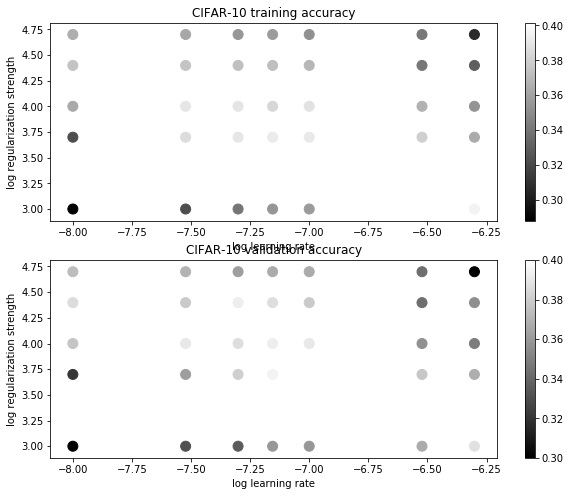

In [37]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [38]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

linear SVM on raw pixels final test set accuracy: 0.385000


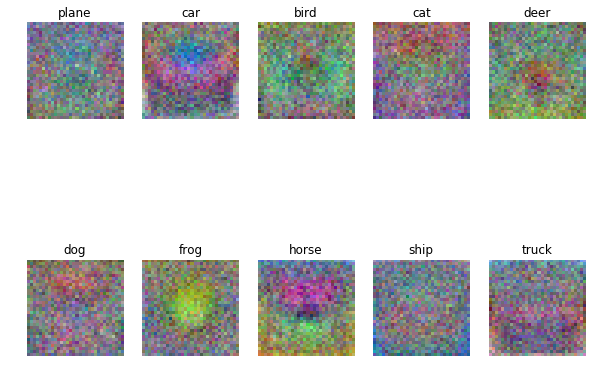

In [39]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Inline question 2:
Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

**Your answer:** *fill this in*